https://camelyon16.grand-challenge.org/Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from fastai.vision import *
sys.path.append("dev/")

In [4]:
path = Path('../data/histopathologic/')

In [5]:
path.ls()

[PosixPath('../data/histopathologic/train'),
 PosixPath('../data/histopathologic/sample_submission.csv'),
 PosixPath('../data/histopathologic/train_labels.csv'),
 PosixPath('../data/histopathologic/logs'),
 PosixPath('../data/histopathologic/models'),
 PosixPath('../data/histopathologic/test')]

In [6]:
len((path/'train').ls()), len((path/'test').ls())

(220025, 57458)

### data

**Important note:** resizing happens before tfms

In [7]:
# For each id in the test set, you must predict a probability that
# center 32x32px region of a patch contains at least one pixel of tumor tissue. 
from fastai.vision.transform import _crop_default
def _rand_center_crop(x, a=40, b=96):
    "x: tensor, center crop an image creating a patch randomly between a,b"
    crop_sz = np.random.randint(a,b)
    return _crop_default(x, crop_sz)

def _rand_center_crop_and_resize(x, a=40, b=96, targ_sz=(96, 96)):
    "x: tensor, center crop an image creating a patch randomly between a,b with a tuple targ_sz"
    crop_sz = np.random.randint(a,b)
    x = _crop_default(x, crop_sz)
    return Image(x).resize((x.shape[0],) + targ_sz).data

center_crop = TfmPixel(_rand_center_crop)
center_crop_and_resize = TfmPixel(_rand_center_crop_and_resize)
center_crop.order = 0
center_crop_and_resize.order = 0
center_crop_tfm, center_crop_and_resize_tfm = center_crop(p=1.), center_crop_and_resize(p=1.)

### cv data

In [8]:
from sklearn.model_selection import KFold

In [9]:
kfold = KFold(5, random_state=42)
n_train = len((path/'train').ls())
cv_idxs = kfold.split(X=range(n_train))
df = pd.read_csv(path/'train_labels.csv')

def get_data(trn_idx, val_idx):
    tfms = get_transforms(True, True, max_rotate=None, max_zoom=1., max_lighting=None,
                      max_warp=0, p_affine=0.5, p_lighting=0.5, xtra_tfms=[])
    data = (ImageList.from_df(df=df, path=path, folder='train', suffix='.tif')
        .split_by_idx(valid_idx=val_idx)
        .label_from_lists(train_labels=list(df['label'].iloc[trn_idx].values),
                                        valid_labels=list(df['label'].iloc[val_idx].values))
        .transform(tfms)
        .databunch()
        .normalize(imagenet_stats))
    data.add_test(ImageList.from_folder(path/'test'))
    return data

In [10]:
cv_data = [get_data(*idxs) for idxs in cv_idxs]

In [11]:
len(cv_data)

5

### model

In [12]:
from metric_utils import AUC
from fastai.callbacks import *

In [13]:
i = 2
fold_num = i
fold_data = cv_data[i]

In [14]:
auc = AUC()
arch = models.vgg16_bn
model_name = arch.__name__ 
os.makedirs(path/f'models/best_of_{model_name}', exist_ok=True)
learn_callbacks = TerminateOnNaNCallback()
learn_callback_fns = [partial(EarlyStoppingCallback, monitor='auc', mode='max', patience=2),
                      partial(SaveModelCallback, monitor='auc', mode='max', every='improvement',
                              name=f'best_of_{model_name}/fold{fold_num}'),
                      partial(CSVLogger, filename=f'logs/{model_name}')]

In [15]:
learn = cnn_learner(data=fold_data, base_arch=arch, metrics=[accuracy, auc], callbacks=learn_callbacks,
                   callback_fns=learn_callback_fns)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03


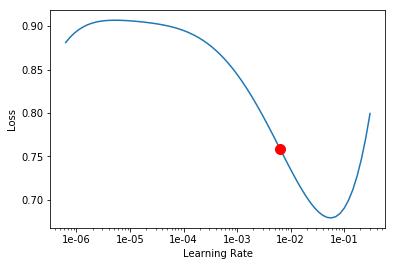

In [16]:
learn.lr_find()
learn.recorder.plot(suggestion=True, k=5)
max_lr = learn.recorder.min_grad_lr

In [17]:
learn.fit_one_cycle(50, max_lr=max_lr)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.221779,0.186077,0.930303,0.971444,11:14
1,0.190489,0.157606,0.942529,0.978789,11:45
2,0.165627,0.146443,0.947415,0.981412,11:45
3,0.150992,0.140091,0.950051,0.985901,11:45
4,0.160027,0.139384,0.949506,0.986524,11:45
5,0.159900,0.135243,0.952483,0.987026,10:14
6,0.159349,0.171221,0.937393,0.983579,11:48
7,0.162757,0.175897,0.933030,0.985759,11:49


Better model found at epoch 0 with auc value: 0.9714441862412213.
Better model found at epoch 1 with auc value: 0.9787889835260817.
Better model found at epoch 2 with auc value: 0.9814117917839775.
Better model found at epoch 3 with auc value: 0.9859006056835131.
Better model found at epoch 4 with auc value: 0.9865241684327389.
Better model found at epoch 5 with auc value: 0.9870261817496502.
Epoch 8: early stopping


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06


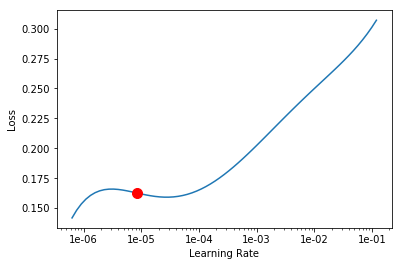

In [18]:
learn.freeze_to(1)
learn.lr_find()
learn.recorder.plot(suggestion=True, k=5)
max_lr = learn.recorder.min_grad_lr

In [19]:
learn.fit_one_cycle(20, max_lr=[max_lr/10, max_lr/3, max_lr])

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.152432,0.127915,0.955710,0.988135,13:00
1,0.142717,0.125809,0.956255,0.988739,13:19
2,0.134324,0.120518,0.958005,0.989576,13:18
3,0.139160,0.116001,0.959800,0.990241,13:20
4,0.128913,0.113924,0.961073,0.990648,13:19
5,0.134259,0.109546,0.962186,0.991297,13:19
6,0.121398,0.107300,0.963095,0.991667,13:19
7,0.116998,0.104425,0.964209,0.992089,13:18
8,0.115898,0.105000,0.963822,0.992393,13:19
9,0.116324,0.100607,0.965208,0.992544,13:19


Better model found at epoch 0 with auc value: 0.9881350460150732.
Better model found at epoch 1 with auc value: 0.9887390936177088.
Better model found at epoch 2 with auc value: 0.9895761609041203.
Better model found at epoch 3 with auc value: 0.9902412892861052.
Better model found at epoch 4 with auc value: 0.9906479180895567.
Better model found at epoch 5 with auc value: 0.9912965447877652.
Better model found at epoch 6 with auc value: 0.9916673197086794.
Better model found at epoch 7 with auc value: 0.992088809997364.
Better model found at epoch 8 with auc value: 0.9923925576151899.
Better model found at epoch 9 with auc value: 0.992544465728909.
Better model found at epoch 10 with auc value: 0.9928745304931669.
Better model found at epoch 12 with auc value: 0.9928883285294098.
Better model found at epoch 13 with auc value: 0.9931589505688112.
Better model found at epoch 14 with auc value: 0.9931755712473836.
Better model found at epoch 16 with auc value: 0.9932275108679233.
Better 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


epoch,train_loss,valid_loss,accuracy,auc,time
0,0.107116,0.096973,0.967504,0.993231,14:07
1,0.102652,0.095892,0.967845,0.993246,14:08
2,0.109560,0.095003,0.968026,0.993310,14:22
3,0.098279,0.096319,0.967481,0.993064,14:51
4,0.107892,0.094730,0.968117,0.993170,16:22


Better model found at epoch 0 with auc value: 0.9932313744467145.
Better model found at epoch 1 with auc value: 0.9932459904381784.
Better model found at epoch 2 with auc value: 0.9933104641772597.


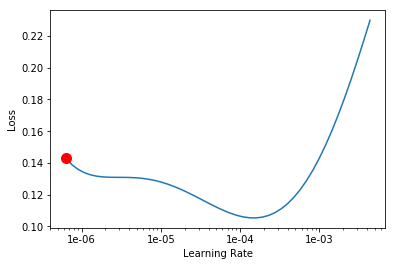

In [20]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True, k=5)
max_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(5, max_lr=[max_lr/10, max_lr/3, max_lr])

### interpret

In [51]:
# reset callbacks - this fails with get_preds
learn.callbacks = []

In [52]:
interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Valid)

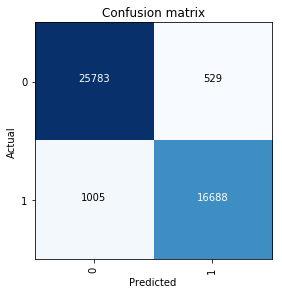

In [53]:
interp.plot_confusion_matrix()

### predict

In [54]:
learn.data.train_ds.y.c2i

{0: 0, 1: 1}

In [55]:
test_preds = learn.get_preds(ds_type=DatasetType.Test)

# pred outputs and dummy labels
probas, _ = test_preds
sample_submission = pd.read_csv(path/'sample_submission.csv')
labels = [o.item() for o in probas[:,1]]
names = [o.name.split('.')[0] for o in data.test_ds.items]
sample_submission['label'] = sample_submission['id'].map(dict(zip(names, labels)))
sample_submission.to_csv(path/f"best_of_{model_name}.csv", index=False)

In [56]:
!kaggle competitions submit -c histopathologic-cancer-detection -f "{path}/models/best_of_{model_name}.csv" -m "init"

100%|███████████████████████████████████████| 3.36M/3.36M [00:03<00:00, 882kB/s]
Successfully submitted to Histopathologic Cancer Detection

### TTA

In [57]:
outs = learn.TTA(ds_type=DatasetType.Test)

In [58]:
# pred outputs and dummy labels
probas, _ = outs

sample_submission = pd.read_csv(path/'sample_submission.csv')
labels = [o.item() for o in probas[:,1]]
names = [o.name.split('.')[0] for o in data.test_ds.items]
sample_submission['label'] = sample_submission['id'].map(dict(zip(names, labels)))
sample_submission.to_csv(path/f"best_of_{model_name}_tta.csv", index=False)

In [60]:
!kaggle competitions submit -c histopathologic-cancer-detection -f "{path}/models/best_of_{model_name}_tta.csv" -m "init"

100%|███████████████████████████████████████| 3.34M/3.34M [00:03<00:00, 975kB/s]
Successfully submitted to Histopathologic Cancer Detection

### INTERPRET